# Augmentation Method #3 - DTW and Interpolation
<br><br>
- Implementation of the third augmentation method Interpolation using Dynamic Time Warping
- Take two time series, align them using DTW and then get produce a new time series usng the values of the aligned time series

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randrange
import rocket
import mpdatasets
from dtw import *

In [23]:
train_x, train_y, test_x, test_y = mpdatasets.load_datasets()

<br><br>
### Begin with taking the averages between two time series without DTW
- First, try seeing if simply producing an new time series from the corresponding values in two others gives good results
- Takes an average of the values at each index of the time series
- Does not first align the series

In [1]:
def interpolate(df_x, df_y, factor, randomize):
    
    # The two time series must have the same class label
    # Therefore the labels are added to time series dataframe
    # and the dataframe is then sorted on this label column
    frame_x = df_x.copy()
    frame_x['Label'] = df_y.tolist()
    frame_x = frame_x.sort_values(by=['Label'])
    frame_x.reset_index(drop=True, inplace=True)
    
    # Once sorted the column is then stored in labels so we have the matching labels
    # after dropping it from frame_x
    labels = frame_x.loc[:,'Label']
    frame_x = frame_x.drop(['Label'], axis=1)

    aug_x = []
    aug_y = []
    
    for i in range(1, frame_x.shape[0]):
        
        body_parts = []
        
        # If the following label matches, get the average of all series in the two rows
        if labels[i-1] == labels[i]:       
            for j in range(frame_x.shape[1]):
                new_timeseries = (frame_x.iloc[i - 1][j] * factor) + (frame_x.iloc[i][j] * (1 - factor))
                body_parts.append(new_timeseries)
            aug_y.append(labels[i])
            aug_x.append(body_parts)
        
    return pd.DataFrame(aug_x), aug_y

<br><br>
- The impact of taking a simple average between two series without performing any alignment of them using DTW
- Produces the below accuracy

Accuracy: 83.8655462184874

In [25]:
interpolate_x, interpolate_y = interpolate(train_x, train_y, 0.5, False)
interpolate_x.columns = ['Neck_X', 'RShoulder_X', 'RElbow_X', 'RWrist_X', 'LShoulder_X', 'LElbow_X', 'LWrist_X', 'MidHip_X', 'RHip_X', 'RKnee_X', 'RAnkle_X', 'LHip_X', 'LKnee_X', 'LAnkle_X', 'REar_X', 'LEar_X', 'LHeel_X', 'RHeel_X', 'Neck_Y', 'RShoulder_Y', 'RElbow_Y', 'RWrist_Y', 'LShoulder_Y', 'LElbow_Y', 'LWrist_Y', 'MidHip_Y', 'RHip_Y', 'RKnee_Y', 'RAnkle_Y', 'LHip_Y', 'LKnee_Y', 'LAnkle_Y', 'REar_Y', 'LEar_Y', 'LHeel_Y', 'RHeel_Y']

aug_train_x = pd.concat([train_x, interpolate_x], axis=0, ignore_index=True)
aug_train_y = np.append(train_y, interpolate_y, axis=0)

acc, preds = rocket.run_classifier(aug_train_x, aug_train_y, test_x, test_y)
print(acc)

[Pipeline] ............ (step 1 of 3) Processing rocket, total= 4.2min
[Pipeline] ......... (step 2 of 3) Processing normalise, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.3s
83.8655462184874


<br><br>
### Visualise how DTW works

- To get a better understanding of how it works, DTW is run on two time series and plotted below

- Align the two time series and plot the result

In [26]:
x = train_x.loc[0]['RWrist_Y']
y = train_x.loc[2]['RWrist_Y']

In [27]:
alignment = dtw(x, y, keep_internals=True,  step_pattern=rabinerJuangStepPattern(2,"c"))

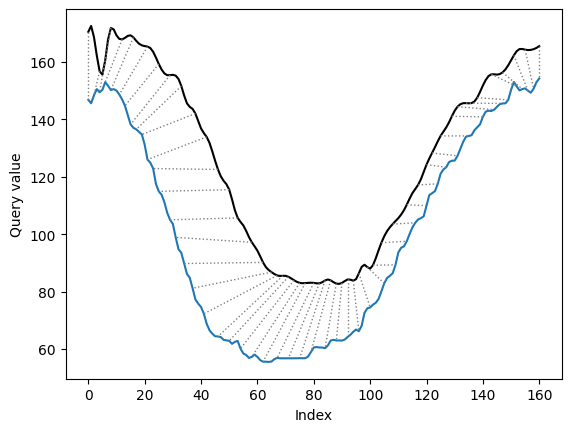

In [28]:
plot = alignment.plot(type="twoway")
fig = plot.get_figure()
fig.savefig('Images/DTW.png')

- Take a slice of each time series to get a closer look at how the alignment works
- Dotted lines connecting the points of the series at which they are aligned
- Some points in a time series are aligned with two in the other

In [29]:
alignment2 = dtw(x[:60], y[:60], keep_internals=True,  step_pattern=rabinerJuangStepPattern(2,"c"))

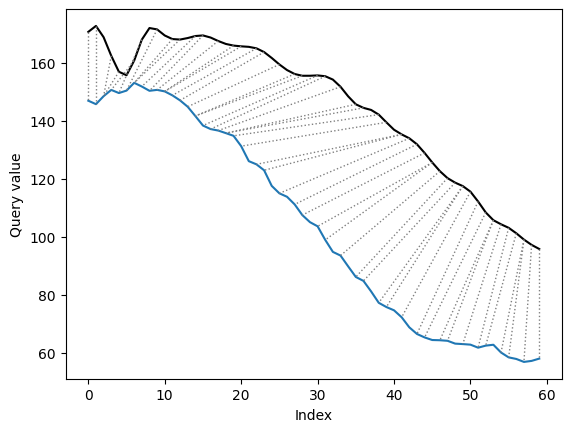

In [30]:
plot = alignment2.plot(type="twoway")
fig = plot.get_figure()
fig.savefig('Images/DTWSlice.png')

<br><br>
### Examine how the alignment is stored
- Examine how the DTW class actaully represents the alignment
- Two arrays corresponding to the two input series are created
- An element in an array is repeated when it's aligned with two values in the other time series
- The elements in the two arrays thus show at what time steps the two input time series are aligned

In [31]:
alignment3 = dtw(x[:15], y[:15], keep_internals=True,  step_pattern=rabinerJuangStepPattern(2,"c"))

alignment3.index1

array([ 0,  1,  1,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13,
       14, 14])

In [32]:
alignment3.index2

array([ 0,  1,  2,  3,  4,  5,  5,  6,  6,  7,  7,  8,  9,  9, 10, 11, 12,
       13, 14])

- Visualisation showing how the values in the arrays correspond to alignment of the time series

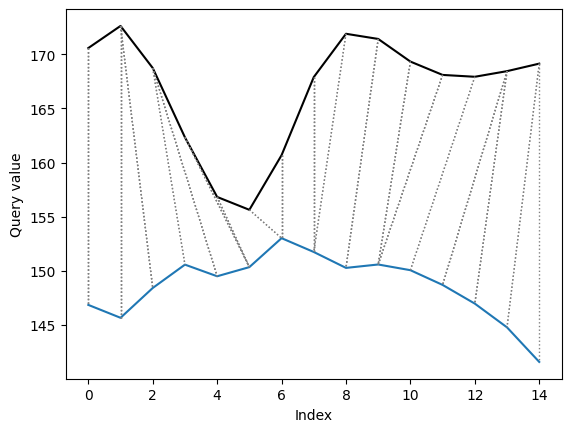

In [33]:
plot = alignment3.plot(type="twoway")
fig = plot.get_figure()
fig.savefig('Images/DTWClose.png')

<br><br>
### Perform DTW then get interpolated series
- dtw_interpolate takes two pandas DataFrames as inputs
- df_x containing the samples, and df_y containing the corresponding class labels
- Groups and splits the dataset by class label, passing each into dtw_generate()

In [ ]:
def dtw_interpolate(df_x, df_y, randomise=False):
    
    frame_x = df_x.copy()
    frame_x['Label'] = df_y.tolist()
    
    aug_x = pd.DataFrame()
    aug_y = []
    
    # Group dataframe by label, then pass each grouped dataframe
    for label, label_df in frame_x.groupby(by=['Label']):
        temp_x = dtw_generate(label_df.iloc[:,:-1], randomise)
        # Returned df temp_x should all be assigned the label of the dataframe 
        # Creates array of length 'temp_x' so it matches the values in temp_x
        aug_y = np.append(aug_y, [label] * len(temp_x))
        aug_x = pd.concat([aug_x, temp_x], axis=0, ignore_index=True)
        
    return aug_x, aug_y

<br><br>
- dtw_generate takes a DataFrame and for each multivariate time series in it, produces an interpolated time series using the time series following it
- Dynamic Time Warping is used to first align the time series
- At the aligned values, the average is taken and applied to this alignment

In [2]:
# Aligns with DTW then produces interpolated time series
def dtw_generate(dfx, randomise):
    
    aug_df = []
    if randomise:
        #Randomises order of rows
        dfx = dfx.sample(frac=1).reset_index(drop=True) 
    
    for i in range(1, dfx.shape[0]):
        
        body_parts = []
        
        # For each row, align it with the previous row
        # Use the returned arrays to match the inices in the two time series
        # and get the mean of the two or 3 values
        for j in range(dfx.shape[1]):
            alignment = dtw(dfx.iloc[i-1][j], dfx.iloc[i][j], keep_internals=True,  step_pattern=rabinerJuangStepPattern(2,"c"))
            warp_a = alignment.index1
            warp_b = alignment.index2

            new_timeseries = []
            
            # Loop through all values in the arrays
            # If a value is repeated in the array, that indicates that it is aligned with 2 points 
            # in the other series
            # Otherwise it is just the mean between the two aligned values 
            m = 1
            while m < len(warp_a):
                if(warp_a[m] == warp_a[m-1]):
                    interpolated_value = dfx.iloc[i-1][j][warp_a[m-1]] + dfx.iloc[i][j][warp_b[m-1]] + dfx.iloc[i][j][warp_b[m]]
                    interpolated_value /= 3
                    m += 2
                else:
                    interpolated_value = dfx.iloc[i-1][j][warp_a[m-1]] + dfx.iloc[i][j][warp_b[m-1]]
                    interpolated_value /= 2
                    m += 1
                
                new_timeseries.append(interpolated_value)
            if len(new_timeseries) != len(dfx.iloc[0][0]):
                new_timeseries.append(new_timeseries[-1])
            body_parts.append(pd.Series(new_timeseries))
        aug_df.append(body_parts)
    aug_df = pd.DataFrame(aug_df)
    aug_df.columns = dfx.columns
    return aug_df

<br><br>
### Plot two time series and the resulting DTW-Interpolated series
- Takes part of the above functions to apply the operation to two single time series
- The influence of one time series on the shape of the augmented one can be easily seen at the bottom of the curve

In [34]:
alignment = dtw(train_x.loc[1]['LWrist_Y'], train_x.loc[2]['LWrist_Y'], keep_internals=True,  step_pattern=rabinerJuangStepPattern(2,"c"))
warp_a = alignment.index1
warp_b = alignment.index2

new_timeseries = []
            
m = 1
while m < len(warp_a):
    if(warp_a[m] == warp_a[m-1]):
        interpolated_value = train_x.loc[1]['LWrist_Y'][warp_a[m-1]] + train_x.loc[2]['LWrist_Y'][warp_b[m-1]] + train_x.loc[2]['LWrist_Y'][warp_b[m]]
        interpolated_value /= 3
        m += 2
    else:
        interpolated_value = train_x.loc[1]['LWrist_Y'][warp_a[m-1]] + train_x.loc[2]['LWrist_Y'][warp_b[m-1]]
        interpolated_value /= 2
        m += 1
                
    new_timeseries.append(interpolated_value)
new_timeseries.append(new_timeseries[-1])

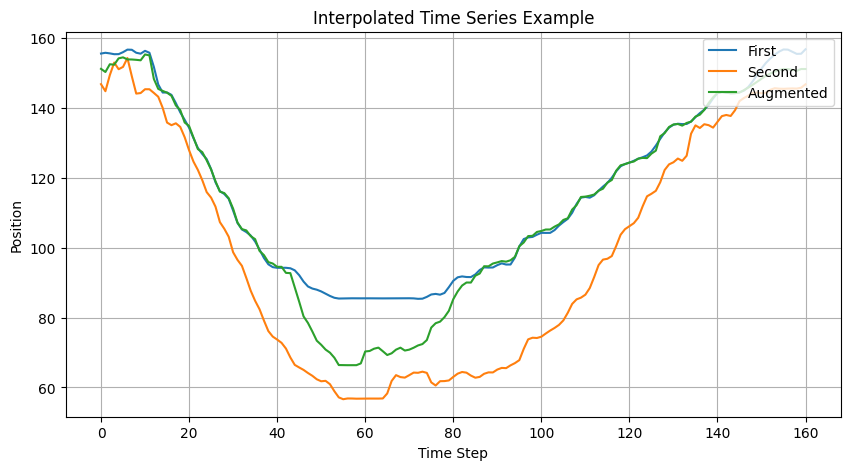

In [35]:
plt.figure(figsize=(10, 5))

plt.title("Interpolated Time Series Example")

plt.plot(train_x.loc[1]['LWrist_Y'], label='First')
plt.plot(train_x.loc[2]['LWrist_Y'], label='Second')
plt.plot(new_timeseries, label='Augmented')
plt.grid()
plt.xlabel("Time Step")
plt.ylabel("Position")

plt.legend(loc='upper right')
plt.savefig('Images/Interpolation.png')

plt.show()

### Run Rocket on Augmented Dataset
- Perform the augmentation method on the dataset and add it to the original samples
- Run the dataset on the ROCKET classifier
- Results in the below accuracy


Accuracy: 86.38655462184875

In [439]:
aug_x, aug_y = dtw_interpolate(train_x, train_y, False)
aug_train_x = pd.concat([train_x, aug_x], axis=0, ignore_index=True)
aug_train_y = train_y
aug_train_y = np.append(aug_train_y, aug_y, axis=0)

acc, preds = rocket.run_classifier(aug_train_x, aug_train_y, test_x, test_y)
print(f"Accuracy: {acc}")

[Pipeline] ............ (step 1 of 3) Processing rocket, total= 4.0min
[Pipeline] ......... (step 2 of 3) Processing normalise, total=   1.3s
[Pipeline] ............. (step 3 of 3) Processing model, total=   9.1s
Accuracy: 86.38655462184875
